In [322]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from collections import Counter
import random

#Leemos archivos csv en los dataframes

user_o_df = pd.read_csv('User_O.csv')
user_j_df = pd.read_csv('User_J.csv')
user_b_df = pd.read_csv('User_B.csv')
user_a_df = pd.read_csv('User_A.csv')
spotify_songs_df = pd.read_csv('spotify_songs.csv')



In [323]:
# Preprosesar datos

spotify_songs_df.dropna(subset=['track_name','track_artist'],inplace=True)
spotify_songs_df['track'] = spotify_songs_df['track_name'] + ' - ' + spotify_songs_df['track_artist']

for user_df in [user_o_df, user_j_df, user_b_df, user_a_df]:
    user_df['track'] = user_df['Song'] + ' - ' + user_df['Artist']
    
    

In [324]:
# Encontramos unas canciones comunes y preparamos datos para recomendaciones

user_dfs = [user_o_df, user_j_df, user_b_df, user_a_df]
user_common_dfs = []
user_tracks_list = []
user_features_list = []

for user_df in user_dfs:
    #if para saber si la cancion del suario se encuentra en la lista de canciones de spotify
    user_common_df = user_df[user_df['track'].isin(spotify_songs_df['track'])]
    user_common_dfs.append(user_common_dfs)
    user_tracks = user_common_df[['Id','track']]
    user_tracks_list.append(user_tracks)
    
    songs_features = spotify_songs_df[['track_id', 'track', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
    user_features = pd.merge(songs_features,user_tracks, on='track')
    user_features.drop('track', axis=1, inplace=True)
    user_features_list.append(user_features)

In [325]:
# Escalar características y calcular similitud

scaler = StandardScaler()
songs_features_scaled = scaler.fit_transform(songs_features.select_dtypes(include='number'))

user_similarity_list = []
for user_features in user_features_list:
    user_features_scaled = scaler.transform(user_features.select_dtypes(include='number'))
    user_similarity = cosine_similarity(user_features_scaled, songs_features_scaled)
    user_similarity_list.append(user_similarity)

In [326]:
#Obtenemos recomendaciones basadas en similitud 

user_recommendations_list = []
for user_similarity in user_similarity_list:
    top_indices = user_similarity.argsort()[:, -5:][:, ::-1]
    recommendations = songs_features.iloc[top_indices.flatten()].drop_duplicates()
    user_recommendations_list.append(recommendations)


In [327]:
# Recomendar playlists existentes
playlist_tracks = spotify_songs_df.groupby(['playlist_id', 'playlist_name'])['track_id'].apply(list).reset_index()

def recommend_existing_playlist(user_tracks):
    playlist_tracks['common_tracks_count'] = playlist_tracks['track_id'].apply(lambda x: get_common_tracks_count(x, user_tracks['Id']))
    top_playlists = playlist_tracks.nlargest(2, 'common_tracks_count')[['playlist_name', 'common_tracks_count']]
    return top_playlists

def get_common_tracks_count(list1, list2):
    return len(set(list1).intersection(set(list2)))

user_existing_recommendations_list = []
for user_tracks in user_tracks_list:
    existing_recommendations = recommend_existing_playlist(user_tracks)
    user_existing_recommendations_list.append(existing_recommendations)

In [328]:
# Creamos las nuevas playlists
songs_features = songs_features.drop(['track_id', 'track'], axis=1)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(songs_features_scaled)

def create_new_playlist(user_tracks, cluster_labels, all_song_data):
    user_track_ids = user_tracks['Id'].tolist()
    user_tracks_data = all_song_data[all_song_data['track_id'].isin(user_track_ids)]
    
    # Get indices of user tracks in all_song_data based on 'track_id'
    user_tracks_indices = all_song_data[all_song_data['track_id'].isin(user_tracks_data['track_id'])].index 
    
    user_cluster_labels = cluster_labels[user_tracks_indices]
    
    most_frequent_cluster = Counter(user_cluster_labels).most_common(2)

    # Filter candidate tracks based on 'track_id'
    # candidate_tracks = all_song_data[cluster_labels == most_frequent_cluster]['track_id']
    # candidate_tracks = candidate_tracks[~candidate_tracks.isin(user_tracks_data['track_id'])]
    new_playlist_track = []
    for cluster_label, _ in most_frequent_cluster:
        # Filter candidate tracks based on 'track_id'
        candidate_tracks = all_song_data[cluster_labels == cluster_label]['track_id']
        candidate_tracks = candidate_tracks[~candidate_tracks.isin(user_tracks_data['track_id'])]

        new_playlist_tracks = random.sample(list(candidate_tracks), 5)
        new_playlist = all_song_data[all_song_data['track_id'].isin(new_playlist_tracks)]
        new_playlist_track.append(new_playlist)

    return new_playlist_track

user_new_playlist_list = []
for user_tracks in user_tracks_list:
    new_playlist = create_new_playlist(user_tracks, cluster_labels, spotify_songs_df)
    user_new_playlist_list.append(new_playlist)
    

In [329]:
# Se combinan las recomendaciones de usuario con el DataFrame spotify_songs_df para obtener información sobre el género y el subgénero.
for i in range(len(user_recommendations_list)):
    user_recommendations_list[i] = pd.merge(user_recommendations_list[i], spotify_songs_df[['track_id', 'playlist_genre', 'playlist_subgenre']], on='track_id', how='left')



In [330]:
#imprimimos las recomendaciones por usuario
user_names = ['User O', 'User J', 'User B', 'User A']
for i in range(len(user_names)):
    # Combinar `user_tracks[i]` con `spotify_songs_df` para obtener `playlist_genre` y `playlist_subgenre`
    user_tracks_with_genre = pd.merge(user_tracks_list[i], spotify_songs_df[['track_id', 'playlist_genre', 'playlist_subgenre']], left_on='Id', right_on='track_id')
    
    print(f"\nRecomendaciones para {user_names[i]}:")
    print("\nPlaylists Existentes:")
    print(user_existing_recommendations_list[i].to_markdown(index=False))
    print("\nNuevas Playlists:")
    for j, new_playlist in enumerate(user_new_playlist_list[i]):
        print(f"\n  Playlist {j+1}:")
        print(new_playlist[['track_name', 'track_artist', 'playlist_genre', 'playlist_subgenre']].head(5).to_markdown(index=False))
    print("\nRecomendaciones basadas en similitud coseno:")
    print(user_recommendations_list[i][['track', 'playlist_genre', 'playlist_subgenre']].head(5).to_markdown(index=False))


Recomendaciones para User O:

Playlists Existentes:
| playlist_name                     |   common_tracks_count |
|:----------------------------------|----------------------:|
| Soda Stereo – El Ultimo Concierto |                     4 |
| Permanent wave                    |                     1 |

Nuevas Playlists:

  Playlist 1:
| track_name     | track_artist    | playlist_genre   | playlist_subgenre         |
|:---------------|:----------------|:-----------------|:--------------------------|
| Over You       | Daughtry        | rock             | permanent wave            |
| Mockingbird    | Dylan 'N' Alice | rock             | hard rock                 |
| I'm Going Like | Hallman         | latin            | tropical                  |
| TRN IT UP      | Matt Watkins    | edm              | big room                  |
| True           | Maestro Harrell | edm              | progressive electro house |

  Playlist 2:
| track_name   | track_artist   | playlist_genre   | playlist_

In [331]:
"Algoritmo que realiza la evaluacion de calidad depende del algoritmo anterior para funcionar"

from sklearn.metrics import pairwise_distances
import numpy as np



In [332]:
# Función para calcular la precisión
# Mide las recomendaciones mas relevantes entre todas las recomendaciones realizadas
def calculate_precision(user_recommendations, user_tracks):
    """Calcula la precisión de las recomendaciones para un usuario.

    Args:
        user_recommendations (DataFrame): DataFrame con las recomendaciones para el usuario.
        user_tracks (DataFrame): DataFrame con las canciones en la playlist del usuario.

    Returns:
        float: Precisión de las recomendaciones.
    """
    user_genres_subgenres = set(user_tracks[['playlist_genre', 'playlist_subgenre']].values.flatten())
    recommended_genres_subgenres = set(user_recommendations[['playlist_genre', 'playlist_subgenre']].values.flatten())
    relevant_recommendations = len(user_genres_subgenres.intersection(recommended_genres_subgenres))
    total_recommendations = len(user_recommendations)
    return relevant_recommendations / total_recommendations if total_recommendations > 0 else 0

In [333]:
# Función para calcular el recall
# Mide la proporcion de los elementos que han sido mas relevantes que fueron recomendados
# Un recall alto indica que el sistema es capaz de encontrar una gran parte de los elementos que podrían ser de interés para el usuario.
def calculate_recall(user_recommendations, user_tracks):
    """Calcula el recall de las recomendaciones para un usuario.

    Args:
        user_recommendations (DataFrame): DataFrame con las recomendaciones para el usuario.
        user_tracks (DataFrame): DataFrame con las canciones en la playlist del usuario.

    Returns:
        float: Recall de las recomendaciones.
    """
    user_genres_subgenres = set(user_tracks[['playlist_genre', 'playlist_subgenre']].values.flatten())
    recommended_genres_subgenres = set(user_recommendations[['playlist_genre', 'playlist_subgenre']].values.flatten())
    relevant_recommendations = len(user_genres_subgenres.intersection(recommended_genres_subgenres))
    total_relevant = len(user_genres_subgenres)
    return relevant_recommendations / total_relevant if total_relevant > 0 else 0

In [334]:
# Función para calcular la diversidad (índice de Gini)
# Mide la variedad de las recomendaciones 
def calculate_diversity(user_recommendations):
    """Calcula la diversidad de las recomendaciones para un usuario utilizando el índice de Gini.

    Args:
        user_recommendations (DataFrame): DataFrame con las recomendaciones para el usuario.

    Returns:
        float: Diversidad de las recomendaciones (índice de Gini).
    """
    genre_counts = user_recommendations['playlist_genre'].value_counts().values
    subgenre_counts = user_recommendations['playlist_subgenre'].value_counts().values
    all_counts = np.concatenate([genre_counts, subgenre_counts])

    # Normalizar los conteos para que sumen 1
    all_counts = all_counts / all_counts.sum()

    # Calcular el índice de Gini
    n = len(all_counts)
    all_counts = all_counts.tolist()
    all_counts.sort()
    gini = sum((2 * i - n - 1) * x for i, x in enumerate(all_counts)) / (n * sum(all_counts))
    return gini

In [335]:
# Función para calcular la novedad
# Mide la capacidad del sistema para recomendar elementos que el usuario no conoce o no ha escuchado recientemente
def calculate_novelty(user_recommendations, user_tracks, spotify_songs_df):
    """Calcula la novedad de las recomendaciones para un usuario.

    Args:
        user_recommendations (DataFrame): DataFrame con las recomendaciones para el usuario.
        user_tracks (DataFrame): DataFrame con las canciones en la playlist del usuario.
        spotify_songs_df (DataFrame): DataFrame con todas las canciones de Spotify.

    Returns:
        float: Novedad de las recomendaciones.
    """
    recommended_track_ids = user_recommendations['track_id'].tolist()
    recommended_popularity = spotify_songs_df[spotify_songs_df['track_id'].isin(recommended_track_ids)]['track_popularity'].mean()

    user_track_ids = user_tracks['Id'].tolist()
    user_popularity = spotify_songs_df[spotify_songs_df['track_id'].isin(user_track_ids)]['track_popularity'].mean()

    return user_popularity - recommended_popularity

In [336]:
# Combinar `user_tracks[i]` con `spotify_songs_df` para obtener `playlist_genre` y `playlist_subgenre`
user_tracks_with_genre = [pd.merge(user_track, spotify_songs_df[['track_id', 'playlist_genre', 'playlist_subgenre']], left_on='Id', right_on='track_id') for user_track in user_tracks_list]

# Calcular y mostrar las métricas para cada usuario
user_names = ['User O', 'User J', 'User B', 'User A']

In [337]:
for i in range(len(user_names)):
    precision = calculate_precision(user_recommendations_list[i], user_tracks_with_genre[i])  # Usar user_tracks_with_genre
    recall = calculate_recall(user_recommendations_list[i], user_tracks_with_genre[i])      # Usar user_tracks_with_genre
    diversity = calculate_diversity(user_recommendations_list[i])
    novelty = calculate_novelty(user_recommendations_list[i], user_tracks_with_genre[i], spotify_songs_df)  # Usar user_tracks_with_genre

    print(f"\nMétricas para {user_names[i]}:")
    print(f"Precisión: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Diversidad (Índice de Gini): {diversity:.2f}")
    print(f"Novedad: {novelty:.2f}")

    # Interpretación de los resultados
    print("\nInterpretación:")
    if precision > 0.5:
        print("  - Las recomendaciones son bastante relevantes a los gustos del usuario.")
    else:
        print("  - Las recomendaciones podrían ser más relevantes a los gustos del usuario.")

    if recall > 0.5:
        print("  - Se está cubriendo una buena parte de los géneros y subgéneros que le gustan al usuario.")
    else:
        print("  - Las recomendaciones podrían explorar más géneros y subgéneros que le gustan al usuario.")

    if diversity > 0.5:
        print("  - Las recomendaciones son diversas en términos de géneros y subgéneros.")
    else:
        print("  - Las recomendaciones podrían ser más diversas en términos de géneros y subgéneros.")

    if novelty > 0:
        print("  - Las recomendaciones incluyen canciones menos populares (más novedosas) que las que el usuario suele escuchar.")
    else:
        print("  - Las recomendaciones se inclinan hacia canciones populares que el usuario podría ya conocer.")


Métricas para User O:
Precisión: 0.12
Recall: 1.00
Diversidad (Índice de Gini): 0.50
Novedad: 14.21

Interpretación:
  - Las recomendaciones podrían ser más relevantes a los gustos del usuario.
  - Se está cubriendo una buena parte de los géneros y subgéneros que le gustan al usuario.
  - Las recomendaciones son diversas en términos de géneros y subgéneros.
  - Las recomendaciones incluyen canciones menos populares (más novedosas) que las que el usuario suele escuchar.

Métricas para User J:
Precisión: 0.09
Recall: 1.00
Diversidad (Índice de Gini): 0.50
Novedad: 6.14

Interpretación:
  - Las recomendaciones podrían ser más relevantes a los gustos del usuario.
  - Se está cubriendo una buena parte de los géneros y subgéneros que le gustan al usuario.
  - Las recomendaciones podrían ser más diversas en términos de géneros y subgéneros.
  - Las recomendaciones incluyen canciones menos populares (más novedosas) que las que el usuario suele escuchar.

Métricas para User B:
Precisión: 0.20


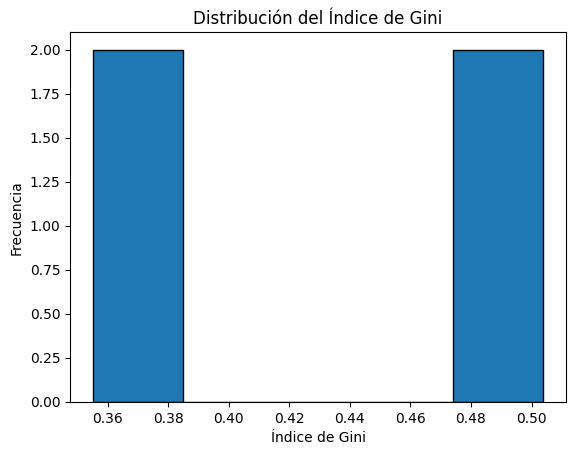

In [338]:
import matplotlib.pyplot as plt
gini_indices =  [calculate_diversity(user_recommendations_list[i]) for i in range(len(user_names))]

plt.hist(gini_indices, bins=5, edgecolor='black')
plt.xlabel('Índice de Gini')
plt.ylabel('Frecuencia')
plt.title('Distribución del Índice de Gini')

plt.show()






In [339]:
gini_indices = [calculate_diversity(user_recommendations_list[i]) for i in range(len(user_names))]

# Calculate statistics
mean_gini = np.mean(gini_indices)
median_gini = np.median(gini_indices)
min_gini = np.min(gini_indices)
max_gini = np.max(gini_indices)

# Print the statistics
print("\nEstadísticas del Índice de Gini:")
print(f"Media: {mean_gini:.2f}")
print(f"Mediana: {median_gini:.2f}")
print(f"Mínimo: {min_gini:.2f}")
print(f"Máximo: {max_gini:.2f}")


Estadísticas del Índice de Gini:
Media: 0.43
Mediana: 0.43
Mínimo: 0.35
Máximo: 0.50
